<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
# OpenEO Platform - User Story 4
### On-demand processing of Sentinel-2 data:
 - ARD compliant
 - With custom parametrization

In [8]:
from eo_utils import *

# On-demand processing of Sentinel-2 data:

## Step 1 -  Area of Interest selection
### Run the next cell, click on the rectangle button and then draw the area over the map like in the following example image
<img src="https://github.com/openEOPlatform/SRR1_notebooks/raw/main/data/images/selection_bbox.jpg"
     alt="rectangle_selection"
     style="float: left; margin-right: 10px;" />

In [9]:
center = [45.85, 11.0]
zoom = 11

eoMap = openeoMap(center,zoom)
addS2Tiles(eoMap)
eoMap.map

Map(center=[45.85, 11.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Get the bounding box from the previous map.

In [10]:
bbox = eoMap.getBbox()
print('west',bbox[0],'\neast',bbox[2],'\nsouth',bbox[1],'\nnorth',bbox[3])

west 10.726089 
east 11.214981 
south 45.768649 
north 45.920755


<img src="https://github.com/openEOPlatform/SRR1_notebooks/raw/main/data/images/Sentinel_2.jpg"
     alt="Sentinel-2"
     style="float: left; margin-right: 10px; width:100px" />
## Step 2 - openEO graph creation for Sentinel-2 L2A
### We will request the same area using different atmospheric correction processes: iCor and Force


1. Open the connection with two back-ends. Please use the openeo-auth tool to configure credentials.
https://open-eo.github.io/openeo-python-client/auth.html#config-files-and-openeo-auth-helper-tool

In [37]:
vito_backend_url = "https://openeo-dev.vito.be"
vito = openeo.connect(vito_backend_url).authenticate_basic()
eodc_backend_url = "https://openeo.eodc.eu/v1.0" 
eodc = openeo.connect(eodc_backend_url).authenticate_basic()

2. Define the process graph for iCor atmospheric correction and save the result.

In [38]:
collection      = 'SENTINEL2_L1C_SENTINELHUB'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}
temporal_extent = ["2018-07-22", "2018-07-24"]
bands           = ["B02","B03","B04","B08","CLM",'B09','B8A','B11','sunAzimuthAngles','sunZenithAngles','viewAzimuthMean','viewZenithMean']

s2_l1c_icor = vito.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)
l2a_icor = s2_l1c_icor.atmospheric_correction(method='iCor').filter_bands(["B02","B03","B04"]).reduce_dimension(reducer="mean", dimension="t").save_result(format="GTIFF")

3. Repeat for FORCE atmospheric correction. Here we use pre-computed analysis ready data (ARD).

    We could also use the atmospheric_correction process similarly as with iCor, but FORCE does not support spatial subsetting and therefore it should process the entire tile, which takes around 45 minutes. Anyway, the pre-computed boa_sentinel_2 has been processed with FORCE too.

In [39]:
collection      = 'boa_sentinel_2'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}
temporal_extent = ["2018-07-22", "2018-07-24"]
bands           = ["B02","B03","B04"]

s2_l2a_force = eodc.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)
l2a_force = s2_l2a_force.reduce_dimension(reducer="mean", dimension="t").save_result(format="GTiff")

4. Create a new batch job for iCor and ask to process it.

In [16]:
job_icor = vito.create_job(l2a_icor.graph)
job_id_icor = job_icor.job_id
if job_id_icor:
    print("Batch job created with id: ",job_id_icor)
    job_icor.start_job()
else:
    print("Error! Job ID is None")

Batch job created with id:  38b4686f-8fa1-4aae-afa8-33e8abe3d7a4


In [17]:
# job_id_icor = '38b4686f-8fa1-4aae-afa8-33e8abe3d7a4'

In [40]:
%time s2_l1c_icor.download("./data/US4/s2_icor.tif", format="GTiff")

CPU times: user 504 ms, sys: 480 ms, total: 984 ms
Wall time: 2min 6s


We can get a description of the job and check its status.

In [28]:
vito = openeo.connect(vito_backend_url).authenticate_basic()
job_icor = vito.job(job_id_icor)
job_description = job_icor.describe_job()
print("Batch job with id: ",job_id_icor, ' is ',job_description['status'])

Batch job with id:  38b4686f-8fa1-4aae-afa8-33e8abe3d7a4  is  finished


5. Do the same for FORCE:

In [19]:
job_force = eodc.create_job(l2a_force.graph)
job_id_force = job_force.job_id
if job_id_force:
    print("Batch job created with id: ",job_id_force)
    job_force.start_job()
else:
    print("Error! Job ID is None")

Batch job created with id:  jb-7d4fa642-1f6b-47dd-bddf-5b0d2e2d81bc


In [20]:
# job_id_force = 'jb-cb437c06-91a8-4ba5-9179-d1b2532aebd9'

In [22]:
eodc = openeo.connect(eodc_backend_url).authenticate_basic()
job_force = eodc.job(job_id_force)
job_description = job_force.describe_job()
print("Batch job with id: ",job_id_force, ' is ',job_description['status'])

Batch job with id:  jb-7d4fa642-1f6b-47dd-bddf-5b0d2e2d81bc  is  finished


6. Once the job status is 'finished', we can visualize the metadata of the results and download them.

In [23]:
results_force = job_force.get_results()

In [30]:
results_icor = job_icor.get_results()
results_icor

<JobResults for job '38b4686f-8fa1-4aae-afa8-33e8abe3d7a4'>

In [31]:
results_force.download_file("./data/US4/s2_force.tif")
results_icor.download_file("./data/US4/s2_icor.tif")

PosixPath('data/US4/s2_icor.tif')

6. Now that the Geotiffs have been downloaded, we can analyze their content and visualize them.

In [41]:
s2_icor = xr.open_rasterio("./data/US4/s2_icor.tif")
s2_force = xr.open_rasterio("./data/US4/s2_force.tif")
print('ICOR OUTPUT:')
s2_icor

ICOR OUTPUT:


<xarray.DataArray (band: 3, y: 1784, x: 3755)>
[20096760 values with dtype=uint16]
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 5.088e+06 5.088e+06 5.088e+06 ... 5.07e+06 5.07e+06
  * x        (x) float64 6.342e+05 6.342e+05 6.342e+05 ... 6.717e+05 6.718e+05
Attributes:
    transform:      (10.0, 0.0, 634210.0, 0.0, -10.0, 5087630.0)
    crs:            +init=epsg:32632
    res:            (10.0, 10.0)
    is_tiled:       1
    nodatavals:     (0.0, 0.0, 0.0)
    scales:         (1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0)
    AREA_OR_POINT:  Area

In [42]:
print('FORCE OUTPUT:')
s2_force

FORCE OUTPUT:


<xarray.DataArray (band: 3, y: 2341, x: 4038)>
[28358874 values with dtype=float64]
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 1.427e+06 1.427e+06 1.427e+06 ... 1.403e+06 1.403e+06
  * x        (x) float64 4.807e+06 4.807e+06 4.807e+06 ... 4.848e+06 4.848e+06
Attributes:
    transform:      (10.0, 0.0, 4807400.0, 0.0, -10.0, 1426540.0)
    crs:            +proj=aeqd +lat_0=53 +lon_0=24 +x_0=5837287.81977 +y_0=21...
    res:            (10.0, 10.0)
    is_tiled:       0
    nodatavals:     (nan, nan, nan)
    scales:         (1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0)
    descriptions:   ('stack-fdde42fade862fb2aacabae6e49d5cb8', 'stack-fdde42f...
    AREA_OR_POINT:  Area

From the previous output, you may notice that the different atmospheric correction processes are applied using different projections: iCor uses the UTM Zone 32 (EPSG:32632) whereas FORCE uses EQUI7.
This is much clearer if we look at the images in their projected grid.

Additionally, we can notice that iCor offer the possibility to apply or not cloud masking, whereas FORCE always apply it.

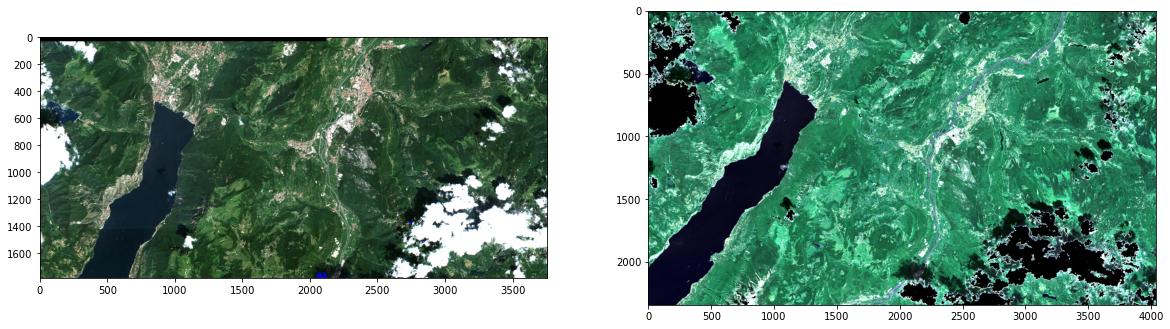

In [43]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))

brg_icor = tone_mapping(s2_icor[2],s2_icor[1],s2_icor[0])
ax1.imshow(brg_icor,cmap='brg')

brg_force = tone_mapping(s2_force[1],s2_force[2],s2_force[0])
ax2.imshow(brg_force,cmap='brg')

If we add the data over the map as new layers, they will be both reprojected to WGS84 (EPSG:4326) and therefore they will overlap.

In [35]:
addLayer(eoMap,'./data/US4/s2_force.tif','FORCE',clip=[0,1800])
addLayer(eoMap,'./data/US4/s2_icor.tif','iCor',clip=[0,1800])
eoMap.map

Map(bottom=187036.0, center=[45.85, 11.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in…